# Graph colouring problem

In this work I would like to explore graph colouring problem using genetic optimization. Main goal is to find optimal set of hyperparameters for GO which will yield fast enough  solutions to graph colouring problem with sufficient reliability. 


We aim to solve GCP by solving multiple k-GCP iteratively : 

First we set some fixed value of k and check whether there is feasible k-colouring of the graph. If feasible solution is found value of k is decreased by one and again check if there is feasible (k-1)-colouring. This process is repeated until there is found k_0 for which no feasible solution is found within bounds given by heuristics (e.g. maximum number of evaluations). k_0+1 is then upper bound for this colouring problem.
2. ...

As individuals in populations we consider every (possibly infeasible) k-colouring.
 Our evaluation function counts number of conflicting vertices in candidate solution (coloring):

$$F(G, c_k) = \frac{1}{2}\sum_{i, j} f(i, j)  $$

where 

$$f(i, j) = 
\begin{cases}
  1 & \text{ak $c_k(i)=c_k(j)$} \\
  0 & \text{inak}
\end{cases}
$$

In [1]:
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

from pathlib import Path
file = Path(pwd).resolve()
root = str(file).split()[0]
sys.path.append(os.path.join(os.path.split(os.path.split(file)[0])[0], 'src'))

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from tqdm import tqdm

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
from heur_graph import GeneticOptimization, UniformMultipoint, RandomCombination, RandomExchange, MinConflict, GraphMutation
from objfun_graph import Graph

# Graph

In our experiments we use benchmark queen5.5 graph with known chromatic number 5. Adjacency of this graph is shown below

<IPython.core.display.Javascript object>


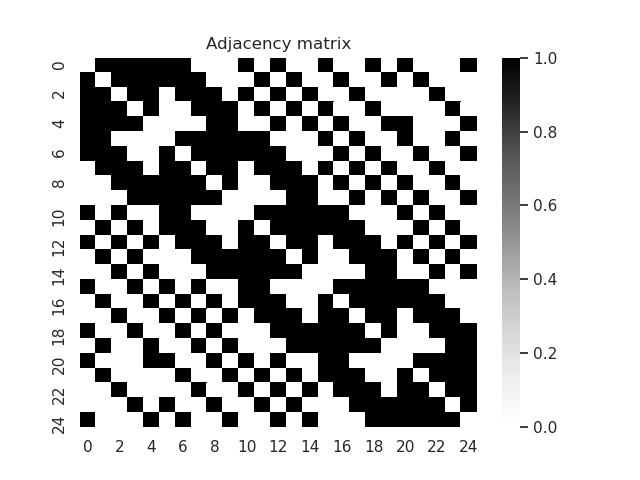

In [12]:
ax = sns.heatmap(g.adjacency_matrix, cmap='Greys')
ax.set_title('Adjacency matrix')
plt.show()

# Experiments

In [4]:
NUM_RUNS = 25
chromatic_number = 5
mutation = GraphMutation()

g = Graph('../../queen5_5.col', 5)

#zeroin = Graph('../../zeroin.i.1.col', 49)
#flat300_28 = Graph('../../flat300_28_0.col.txt', 28)
#r250 = Graph('../../r250.5.col.txt', 65)


### Metrics

As evaluation metrics we consider reliability  denoted as `rel` i.e. fraction of successful solutions/experiments out of all experiments. We also use mean number of evaluations in successful runs  denoted as `mne` and finally feoktistov criterion denoted as `feo` which aims to consider both `rel` and `mne` simultaneously in one metric.

In [5]:
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

### Few more auxiliary functions

In [10]:

def graph_colouring(graph, maxeval, num_runs, N, M, Tsel1, Tsel2, mutation, crossover, obj_type=0):
    """
    function encapsulating experiment logic
    """
    results = []
    
    n_colors = graph.init_chromatic_number

    for n in tqdm(range(num_runs), 'Testing... '):
        while True:
            
            result = GeneticOptimization(graph, maxeval, N=N, M=M, Tsel1=Tsel1, Tsel2=Tsel2, 
                                        mutation=mutation, crossover=crossover).search(n_colors, obj_type)
            result['run'] = n
            result['N'] = N
            result['M'] = M
            result['maxeval'] = maxeval
            result['t1'] = Tsel1
            result['t2'] = Tsel2
            result['obj'] = obj_type
            result['color'] = n_colors + 1
            results.append(result)
            
            
            if result['best_y'] != 0:
                print(f"Graph is {n_colors+1} colorable")
                result['color'] = n_colors + 1
                n_colors = graph.init_chromatic_number
                break
            else:
                n_colors -= 1
                print(f'Found feasible coloring for {n_colors+1} colors')
                
    return pd.DataFrame(results, columns=['run', 'N', 'M', 'maxeval', 't1', 't2', 'color', 'best_x', 'best_y',
                                          'neval', 'obj'])

In [11]:
def transform(df):
    """
    auxiliary transformation function
    """
    if df[df['neval'] != np.inf].empty:
        return pd.DataFrame()
    cc = df[df['neval'] == np.inf].copy()
    oo = out.copy()
    oo.loc[oo['neval'] == np.inf, 'neval'] = 0.
    vv = oo.groupby(['run'])['neval'].sum().values
    cc['n_eval'] = vv
    
    vv = np.where(vv == 0, np.inf, vv)
    cc['num_eval'] = vv
    cc.loc[cc['color'] != chromatic_number, 'num_eval'] = np.inf

    
    cc['eff_num_eval'] = cc['num_eval'] * cc['M']
    cc['eff_n_eval'] = cc['n_eval'] * cc['M']
    
    return cc

### Experiment 1 - Population size

- UniformMultipoint(1) crossover


In [8]:
crossover = UniformMultipoint(1)

maxeval = 200
kk = []

for i in [500, 200, 100, 50, 25, 10, 5]:
    if not os.path.isfile(os.path.join(os.getcwd(), f'ex1_{i}.csv')):
        out = graph_colouring(g, maxeval, NUM_RUNS, i, 2*i, 1, 0.1, mutation, crossover)
        out.to_csv(os.path.join(os.getcwd(), f'ex1_{i}.csv'))
    
    out = pd.read_csv(os.path.join(os.getcwd(), f'ex1_{i}.csv'))
    cc = transform(out)
    kk.append(cc)
        
df1 = pd.concat(kk)

In [9]:
df1.groupby(['N'])['color'].mean()

N
5      7.68
10     6.76
25     6.80
50     6.60
100    6.16
200    6.36
500    6.68
Name: color, dtype: float64

In [10]:
df1.groupby(['N'])['color'].median()

N
5      8
10     7
25     7
50     7
100    6
200    6
500    7
Name: color, dtype: int64

<IPython.core.display.Javascript object>


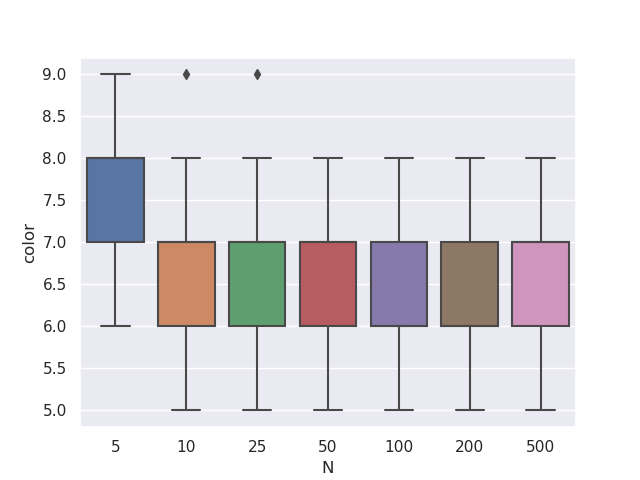

In [11]:
ax = sns.boxplot(x="N", y="color", data=df1)

In [12]:
df1[df1['color'] == chromatic_number].groupby(['N'])['num_eval'].mean()

N
10     565.800000
25     365.000000
50     347.750000
100    226.333333
200    186.600000
500    101.000000
Name: num_eval, dtype: float64

In [15]:
df1[df1['color'] == chromatic_number].groupby(['N'])['eff_num_eval'].mean()

N
10      11316.000000
25      18250.000000
50      34775.000000
100     45266.666667
200     74640.000000
500    101000.000000
Name: eff_num_eval, dtype: float64

<IPython.core.display.Javascript object>


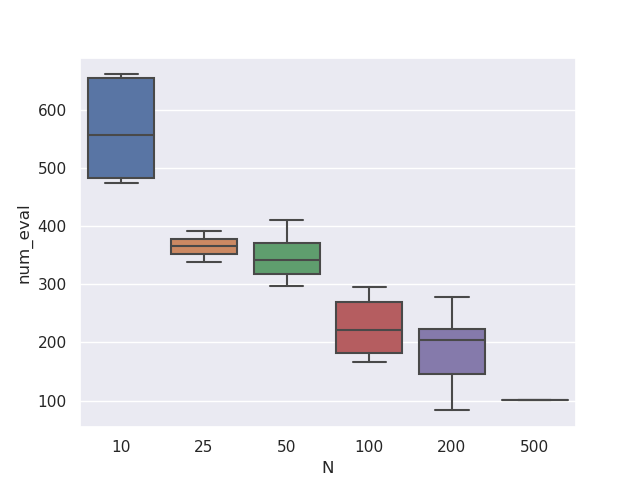

In [16]:
ax = sns.boxplot(x="N", y="num_eval", data=df1[df1['color'] == chromatic_number])

<IPython.core.display.Javascript object>


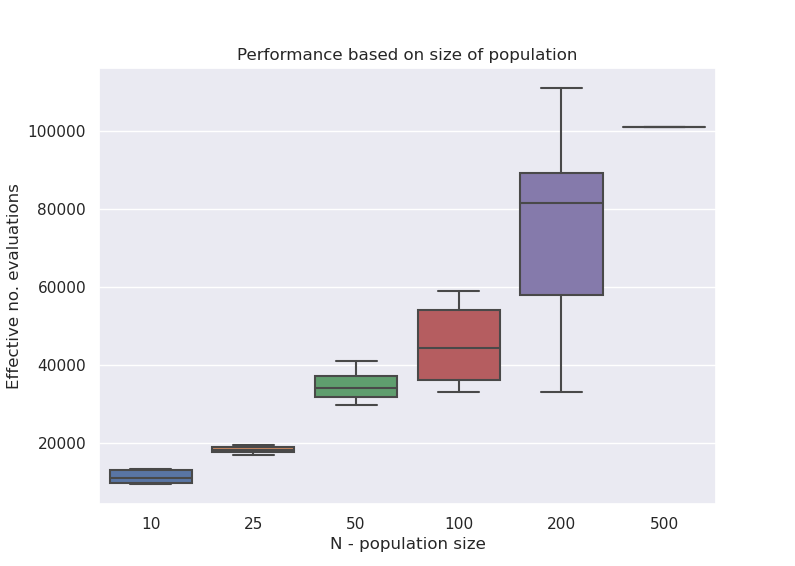

In [17]:
ax = sns.boxplot(x="N", y="eff_num_eval", data=df1[df1['color'] == chromatic_number])
ax.set_title('Performance based on size of population')
ax.set_ylabel('Effective no. evaluations')
ax.set_xlabel('N - population size')
plt.show()

In [18]:
by_N = df1.pivot_table(
    index=['N'],
    values=['num_eval'],
    aggfunc=(rel, mne, feo))['num_eval']



/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
by_N

,feo,mne,rel
N,,,
5,NaN,NaN,0.00
10,2829.000000,565.800000,0.20
25,4562.500000,365.000000,0.08
50,2173.437500,347.750000,0.16
100,943.055556,226.333333,0.24
200,933.000000,186.600000,0.20
500,2525.000000,101.000000,0.04


In [20]:
by_N = df1.pivot_table(
    index=['N'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
by_N

,feo,mne,rel
N,,,
5,NaN,NaN,0.00
10,5.658000e+04,11316.000000,0.20
25,2.281250e+05,18250.000000,0.08
50,2.173438e+05,34775.000000,0.16
100,1.886111e+05,45266.666667,0.24
200,3.732000e+05,74640.000000,0.20
500,2.525000e+06,101000.000000,0.04


In [22]:
by_N['rel'] = by_N['rel'] * 100
by_N['feo'] = np.log2(by_N['feo'])
by_N['mne'] = np.log2(by_N['mne'])

<IPython.core.display.Javascript object>


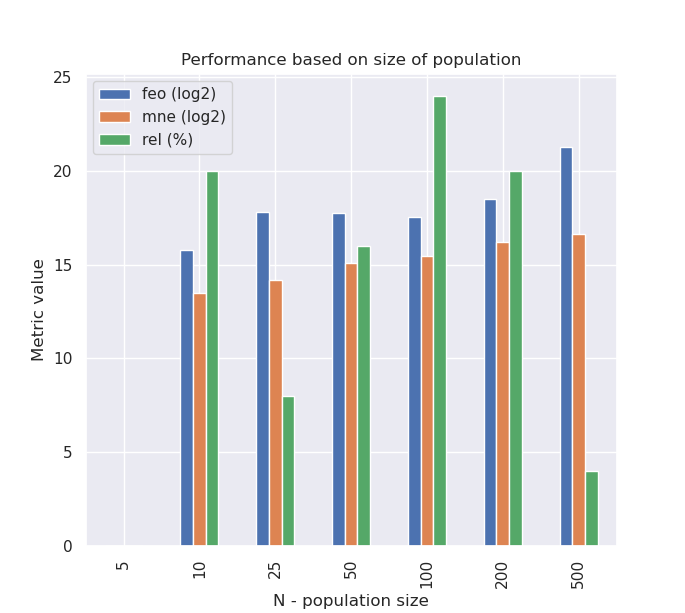

In [23]:
ax = by_N.plot(kind='bar')
ax.set_title('Performance based on size of population')
ax.set_ylabel('Metric value')
ax.set_xlabel('N - population size')
plt.legend(labels=['feo (log2)', 'mne (log2)', 'rel (%)'])
plt.show()

### Experiment 2 - Working population size

- UniformMultipoint(1) crossover
- best population size


In [24]:

crossover = UniformMultipoint(1)

kk = []
maxeval = 200
N=10

for i in [1.5, 2, 3, 5, 7, 10, 20, 100]:
    if not os.path.isfile(os.path.join(os.getcwd(), f'ex2_{i}.csv')):
        out = graph_colouring(g, maxeval, NUM_RUNS, N, int(N*i), 1, 0.1, mutation, crossover)
        out.to_csv(os.path.join(os.getcwd(), f'ex2_{i}.csv'))
    
    out = pd.read_csv(os.path.join(os.getcwd(), f'ex2_{i}.csv'))
    cc = transform(out)
    kk.append(cc)


        
df2 = pd.concat(kk)


In [25]:
df2.groupby(['M'])['color'].mean()

M
15      6.48
20      6.56
30      6.56
50      6.64
70      6.40
100     6.72
200     6.16
1000    6.48
Name: color, dtype: float64

<IPython.core.display.Javascript object>


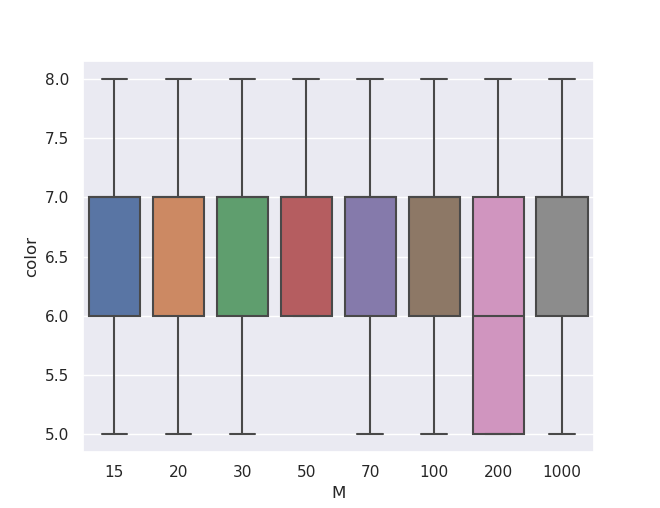

In [26]:
ax = sns.boxplot(x="M", y="color", data=df2)
plt.show()

In [37]:
df2[df2['color'] == chromatic_number].groupby(['M'])['num_eval'].mean()

M
15      598.250000
20      534.600000
30      505.500000
70      328.800000
100     361.666667
200     248.285714
1000    200.000000
Name: num_eval, dtype: float64

In [27]:
df2[df2['color'] == chromatic_number].groupby(['M'])['eff_num_eval'].mean()

M
15        8973.750000
20       10692.000000
30       15165.000000
70       23016.000000
100      36166.666667
200      49657.142857
1000    200000.000000
Name: eff_num_eval, dtype: float64

<IPython.core.display.Javascript object>


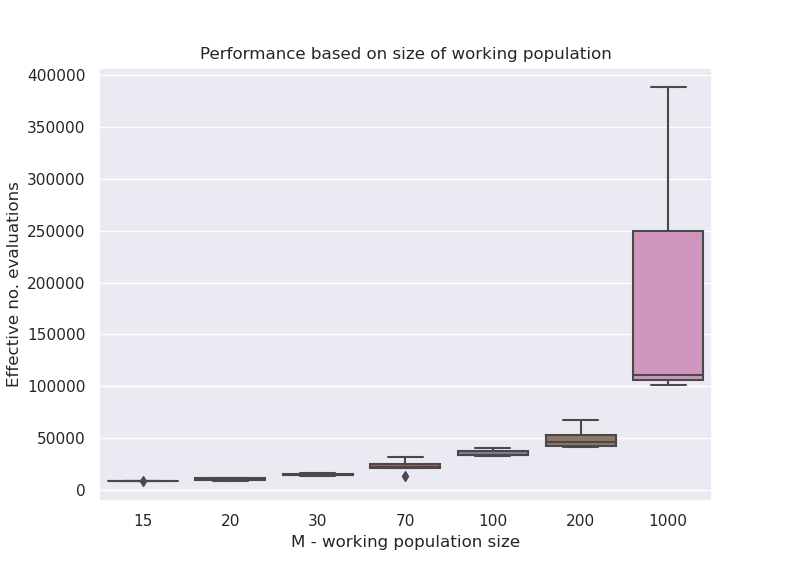

In [28]:
ax = sns.boxplot(x="M", y="eff_num_eval", data=df2[df2['color'] == chromatic_number])
ax.set_title('Performance based on size of working population')
ax.set_ylabel('Effective no. evaluations')
ax.set_xlabel('M - working population size')
plt.show()

In [29]:
by_M = df2.pivot_table(
    index=['M'],
    values=['num_eval'],
    aggfunc=(rel, mne, feo))['num_eval']

by_M

/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feo,mne,rel
M,,,
15,3739.062500,598.250000,0.16
20,2673.000000,534.600000,0.20
30,6318.750000,505.500000,0.08
50,NaN,NaN,0.00
70,1644.000000,328.800000,0.20
100,3013.888889,361.666667,0.12
200,886.734694,248.285714,0.28
1000,1666.666667,200.000000,0.12


In [30]:
by_M = df2.pivot_table(
    index=['M'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_M

/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feo,mne,rel
M,,,
15,5.608594e+04,8973.750000,0.16
20,5.346000e+04,10692.000000,0.20
30,1.895625e+05,15165.000000,0.08
50,NaN,NaN,0.00
70,1.150800e+05,23016.000000,0.20
100,3.013889e+05,36166.666667,0.12
200,1.773469e+05,49657.142857,0.28
1000,1.666667e+06,200000.000000,0.12


### Experiment 3 - selection temperatures

- UniformMultipoint(1) crossover
- best population size
- best working population size


In [39]:
crossover = UniformMultipoint(1)

maxeval = 200
N=10
M=20
kk = []

for i in [0.1, 1, 10]:
    for j in [0.1, 1, 10]:
        if not os.path.isfile(os.path.join(os.getcwd(), f'ex3a_{i}_{j}.csv')):
            out = graph_colouring(g, maxeval, NUM_RUNS, N, M, i, j, mutation, crossover)
            out.to_csv(os.path.join(os.getcwd(), f'ex3a_{i}_{j}.csv'))

        out = pd.read_csv(os.path.join(os.getcwd(), f'ex3a_{i}_{j}.csv'))
        cc = transform(out)
        kk.append(cc)
    
        
df3a = pd.concat(kk)

In [40]:
by_t = df3a.pivot_table(
    index=['t1', 't2'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_t

/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/emanuel/data/miniconda3/envs/ox/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


feo      mne   rel
t1   t2                           
0.1  0.1   139875.0  11190.0  0.08
     1.0   148125.0  11850.0  0.08
     10.0  145500.0  11640.0  0.08
1.0  0.1   112375.0   8990.0  0.08
     1.0   129250.0  10340.0  0.08
     10.0  383500.0  15340.0  0.04
10.0 0.1   333000.0  13320.0  0.04
     1.0        NaN      NaN  0.00

In [41]:
crossover = UniformMultipoint(1)

maxeval = 200
N=10
M=200
kk = []

for i in [0.1, 1, 10]:
    for j in [0.1, 1, 10]:
        if not os.path.isfile(os.path.join(os.getcwd(), f'ex3_{i}_{j}.csv')):
            out = graph_colouring(g, maxeval, NUM_RUNS, N, M, i, j, mutation, crossover)
            out.to_csv(os.path.join(os.getcwd(), f'ex3_{i}_{j}.csv'))

        out = pd.read_csv(os.path.join(os.getcwd(), f'ex3_{i}_{j}.csv'))
        cc = transform(out)
        kk.append(cc)
    
        
df3 = pd.concat(kk)

Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:14<05:43, 14.31s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   8%|▊         | 2/25 [00:31<05:51, 15.29s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  12%|█▏        | 3/25 [00:45<05:24, 14.73s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  16%|█▌        | 4/25 [00:58<04:59, 14.25s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [01:11<04:38, 13.91s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  24%|██▍       | 6/25 [01:25<04:26, 14.05s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [01:46<04:49, 16.06s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  32%|███▏      | 8/25 [02:02<04:32, 16.05s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  36%|███▌      | 9/25 [02:16<04:04, 15.25s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [02:34<04:00, 16.05s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  44%|████▍     | 11/25 [02:49<03:44, 16.02s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  48%|████▊     | 12/25 [03:04<03:21, 15.53s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  52%|█████▏    | 13/25 [03:24<03:22, 16.91s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  56%|█████▌    | 14/25 [03:40<03:02, 16.55s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [03:54<02:38, 15.85s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [04:08<02:16, 15.18s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [04:22<02:00, 15.04s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [04:36<01:43, 14.73s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  76%|███████▌  | 19/25 [04:56<01:36, 16.15s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  80%|████████  | 20/25 [05:10<01:17, 15.47s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  84%|████████▍ | 21/25 [05:26<01:03, 15.80s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [05:41<00:46, 15.50s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [05:54<00:29, 14.68s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:10<00:15, 15.16s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   4%|▍         | 1/25 [00:14<05:46, 14.43s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:29<05:38, 14.72s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  12%|█▏        | 3/25 [00:53<06:23, 17.43s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  16%|█▌        | 4/25 [01:08<05:47, 16.53s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  20%|██        | 5/25 [01:32<06:21, 19.07s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  24%|██▍       | 6/25 [01:56<06:25, 20.31s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [02:12<05:42, 19.02s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  32%|███▏      | 8/25 [02:31<05:25, 19.17s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  36%|███▌      | 9/25 [02:43<04:31, 16.95s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [02:56<03:54, 15.62s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  44%|████▍     | 11/25 [03:15<03:55, 16.82s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  48%|████▊     | 12/25 [03:31<03:35, 16.58s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  52%|█████▏    | 13/25 [03:54<03:43, 18.59s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  56%|█████▌    | 14/25 [04:14<03:26, 18.82s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  60%|██████    | 15/25 [04:32<03:07, 18.75s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  64%|██████▍   | 16/25 [04:54<02:55, 19.52s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [05:07<02:20, 17.61s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [05:20<01:53, 16.16s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [05:34<01:33, 15.65s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  80%|████████  | 20/25 [05:46<01:13, 14.65s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  84%|████████▍ | 21/25 [05:59<00:55, 13.90s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [06:16<00:44, 14.95s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [06:34<00:31, 15.88s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:47<00:14, 14.89s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:14<05:40, 14.19s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:27<05:22, 14.00s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  12%|█▏        | 3/25 [00:44<05:24, 14.77s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  16%|█▌        | 4/25 [01:08<06:12, 17.74s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [01:22<05:28, 16.42s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [01:40<05:23, 17.04s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [01:54<04:47, 15.97s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  32%|███▏      | 8/25 [02:12<04:40, 16.50s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  36%|███▌      | 9/25 [02:26<04:14, 15.93s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [02:41<03:53, 15.54s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [02:55<03:30, 15.03s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  48%|████▊     | 12/25 [03:08<03:08, 14.46s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  52%|█████▏    | 13/25 [03:21<02:50, 14.23s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  56%|█████▌    | 14/25 [03:33<02:28, 13.53s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [03:46<02:13, 13.35s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [03:59<01:58, 13.20s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  68%|██████▊   | 17/25 [04:22<02:07, 15.98s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [04:43<02:02, 17.47s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors


Testing... :  76%|███████▌  | 19/25 [04:54<01:33, 15.62s/it]

Graph is 9 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  80%|████████  | 20/25 [05:07<01:15, 15.02s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  84%|████████▍ | 21/25 [05:20<00:57, 14.39s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [05:33<00:41, 13.89s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [05:47<00:27, 13.79s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:04<00:14, 14.92s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:15<06:06, 15.27s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:28<05:34, 14.56s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  12%|█▏        | 3/25 [00:40<05:05, 13.91s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [00:55<05:00, 14.33s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [01:08<04:34, 13.74s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  24%|██▍       | 6/25 [01:19<04:07, 13.04s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  28%|██▊       | 7/25 [01:32<03:51, 12.88s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  32%|███▏      | 8/25 [01:46<03:47, 13.36s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  36%|███▌      | 9/25 [01:59<03:30, 13.17s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [02:11<03:14, 12.97s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [02:30<03:23, 14.55s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  48%|████▊     | 12/25 [02:43<03:04, 14.22s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  52%|█████▏    | 13/25 [02:55<02:42, 13.57s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  56%|█████▌    | 14/25 [03:07<02:22, 12.97s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [03:23<02:20, 14.07s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  64%|██████▍   | 16/25 [03:42<02:19, 15.55s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  68%|██████▊   | 17/25 [03:58<02:05, 15.67s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [04:22<02:05, 17.97s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  76%|███████▌  | 19/25 [04:37<01:43, 17.33s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  80%|████████  | 20/25 [04:58<01:30, 18.19s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [05:26<01:24, 21.20s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  88%|████████▊ | 22/25 [05:40<00:57, 19.03s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [05:53<00:34, 17.37s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:08<00:16, 16.48s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :   4%|▍         | 1/25 [00:13<05:19, 13.29s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:31<05:39, 14.77s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  12%|█▏        | 3/25 [00:51<06:01, 16.41s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  16%|█▌        | 4/25 [01:15<06:33, 18.72s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  20%|██        | 5/25 [01:40<06:48, 20.40s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  24%|██▍       | 6/25 [01:52<05:41, 17.99s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [02:06<04:59, 16.65s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  32%|███▏      | 8/25 [02:20<04:29, 15.84s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  36%|███▌      | 9/25 [02:34<04:08, 15.50s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  40%|████      | 10/25 [02:57<04:23, 17.55s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [03:14<04:03, 17.41s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  48%|████▊     | 12/25 [03:27<03:30, 16.15s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  52%|█████▏    | 13/25 [03:39<03:00, 15.04s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  56%|█████▌    | 14/25 [03:51<02:33, 13.97s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [04:04<02:16, 13.64s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  64%|██████▍   | 16/25 [04:21<02:11, 14.63s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  68%|██████▊   | 17/25 [04:43<02:15, 16.94s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  72%|███████▏  | 18/25 [04:56<01:50, 15.83s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  76%|███████▌  | 19/25 [05:12<01:35, 15.92s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  80%|████████  | 20/25 [05:35<01:29, 17.86s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  84%|████████▍ | 21/25 [05:46<01:04, 16.03s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [06:04<00:49, 16.57s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [06:17<00:30, 15.41s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:30<00:14, 14.67s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:13<05:34, 13.95s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   8%|▊         | 2/25 [00:35<06:11, 16.15s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  12%|█▏        | 3/25 [00:49<05:42, 15.55s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  16%|█▌        | 4/25 [01:03<05:15, 15.02s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [01:16<04:51, 14.55s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  24%|██▍       | 6/25 [01:38<05:18, 16.77s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  28%|██▊       | 7/25 [01:54<04:57, 16.54s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  32%|███▏      | 8/25 [02:11<04:44, 16.75s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  36%|███▌      | 9/25 [02:25<04:12, 15.79s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  40%|████      | 10/25 [02:42<04:01, 16.12s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [02:55<03:32, 15.18s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  48%|████▊     | 12/25 [03:08<03:11, 14.72s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  52%|█████▏    | 13/25 [03:21<02:50, 14.19s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  56%|█████▌    | 14/25 [03:44<03:04, 16.81s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [03:58<02:38, 15.89s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [04:16<02:28, 16.52s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [04:32<02:10, 16.37s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [04:47<01:50, 15.80s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [05:02<01:34, 15.74s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  80%|████████  | 20/25 [05:17<01:17, 15.49s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  84%|████████▍ | 21/25 [05:34<01:03, 15.81s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [05:47<00:45, 15.15s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  92%|█████████▏| 23/25 [06:08<00:33, 16.77s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:22<00:15, 15.88s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   4%|▍         | 1/25 [00:23<09:26, 23.60s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   8%|▊         | 2/25 [00:40<08:14, 21.48s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  12%|█▏        | 3/25 [00:57<07:22, 20.12s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [01:14<06:48, 19.45s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [01:29<05:56, 17.84s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  24%|██▍       | 6/25 [01:42<05:16, 16.66s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  28%|██▊       | 7/25 [01:58<04:55, 16.40s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  32%|███▏      | 8/25 [02:21<05:11, 18.31s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  36%|███▌      | 9/25 [02:35<04:33, 17.11s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [02:50<04:04, 16.32s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [03:04<03:39, 15.71s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  48%|████▊     | 12/25 [03:31<04:09, 19.16s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  52%|█████▏    | 13/25 [03:50<03:47, 18.92s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  56%|█████▌    | 14/25 [04:04<03:11, 17.41s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  60%|██████    | 15/25 [04:16<02:38, 15.89s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [04:29<02:16, 15.12s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  68%|██████▊   | 17/25 [04:47<02:08, 16.04s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [05:00<01:45, 15.07s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [05:13<01:26, 14.46s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  80%|████████  | 20/25 [05:27<01:11, 14.24s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  84%|████████▍ | 21/25 [05:41<00:57, 14.29s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [06:02<00:48, 16.14s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [06:15<00:30, 15.38s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  96%|█████████▌| 24/25 [06:35<00:16, 16.70s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   4%|▍         | 1/25 [00:18<07:18, 18.25s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:34<06:48, 17.76s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  12%|█▏        | 3/25 [00:53<06:35, 17.97s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [01:08<05:58, 17.09s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  20%|██        | 5/25 [01:26<05:48, 17.45s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [01:43<05:25, 17.15s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  28%|██▊       | 7/25 [01:58<04:57, 16.52s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  32%|███▏      | 8/25 [02:12<04:32, 16.02s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  36%|███▌      | 9/25 [02:25<03:59, 14.99s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [02:39<03:40, 14.67s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  44%|████▍     | 11/25 [02:57<03:37, 15.57s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  48%|████▊     | 12/25 [03:25<04:10, 19.26s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  52%|█████▏    | 13/25 [03:38<03:30, 17.52s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors


Testing... :  56%|█████▌    | 14/25 [03:50<02:55, 15.97s/it]

Graph is 8 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [04:03<02:30, 15.09s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [04:25<02:32, 16.98s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [04:38<02:07, 15.89s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [04:55<01:53, 16.26s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [05:12<01:39, 16.53s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  80%|████████  | 20/25 [05:27<01:19, 15.91s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [05:50<01:12, 18.12s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  88%|████████▊ | 22/25 [06:07<00:53, 17.76s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  92%|█████████▏| 23/25 [06:27<00:36, 18.43s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  96%|█████████▌| 24/25 [06:48<00:19, 19.15s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   4%|▍         | 1/25 [00:20<08:10, 20.45s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:37<07:24, 19.32s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  12%|█▏        | 3/25 [00:52<06:36, 18.04s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  16%|█▌        | 4/25 [01:09<06:11, 17.71s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  20%|██        | 5/25 [01:31<06:23, 19.19s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [01:45<05:34, 17.58s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [02:03<05:18, 17.68s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  32%|███▏      | 8/25 [02:21<05:01, 17.73s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  36%|███▌      | 9/25 [02:41<04:56, 18.56s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  40%|████      | 10/25 [03:02<04:47, 19.19s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [03:19<04:18, 18.49s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  48%|████▊     | 12/25 [03:36<03:54, 18.07s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  52%|█████▏    | 13/25 [03:51<03:25, 17.09s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  56%|█████▌    | 14/25 [04:04<02:56, 16.03s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [04:19<02:35, 15.55s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [04:33<02:16, 15.14s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [04:47<01:59, 14.95s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [05:02<01:43, 14.80s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [05:18<01:30, 15.17s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  80%|████████  | 20/25 [05:35<01:18, 15.77s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [05:55<01:08, 17.17s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [06:11<00:49, 16.63s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  92%|█████████▏| 23/25 [06:36<00:38, 19.06s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [06:49<00:17, 17.22s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... : 100%|██████████| 25/25 [07:04<00:00, 16.98s/it]

Graph is 7 colorable


In [42]:
by_t = df3.pivot_table(
    index=['t1', 't2'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_t

feo           mne   rel
t1   t2                                     
0.1  0.1   420000.000000  33600.000000  0.08
     1.0   307400.000000  61480.000000  0.20
     10.0  750000.000000  30000.000000  0.04
1.0  0.1   415555.555556  49866.666667  0.12
     1.0   307500.000000  49200.000000  0.16
     10.0  386666.666667  46400.000000  0.12
10.0 0.1   370625.000000  59300.000000  0.16
     1.0   375312.500000  60050.000000  0.16
     10.0  304200.000000  60840.000000  0.20

### Experiment 4 - objective function

- UniformMultipoint(1) crossover
- best population size
- best working population size
- best parent selection temperature
- best population selection temperature

In [51]:
crossover = UniformMultipoint(1)

maxeval = 1000
N=10
M=200 # <--------------------------
t1=0.1
t2=1
kk = []


for i in [0, 1]:
    if not os.path.isfile(os.path.join(os.getcwd(), f'ex4_{i}.csv')):
        out = graph_colouring(g, maxeval, NUM_RUNS, N, M, t1, t2, mutation, crossover, i)
        out.to_csv(os.path.join(os.getcwd(), f'ex4_{i}.csv'))
        
    out = pd.read_csv(os.path.join(os.getcwd(), f'ex4_{i}.csv'))
    cc = transform(out)
    kk.append(cc)
    
        
df4 = pd.concat(kk)

Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:48<19:17, 48.22s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [01:36<18:31, 48.30s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  12%|█▏        | 3/25 [02:23<17:31, 47.80s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [03:48<20:36, 58.90s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  20%|██        | 5/25 [04:49<19:50, 59.54s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [05:41<18:08, 57.31s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  28%|██▊       | 7/25 [06:49<18:07, 60.43s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  32%|███▏      | 8/25 [07:38<16:11, 57.16s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  36%|███▌      | 9/25 [08:30<14:51, 55.69s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  36%|███▌      | 9/25 [08:55<15:52, 59.53s/it]


KeyboardInterrupt: 

In [44]:
df4

,Unnamed: 0,run,N,M,maxeval,t1,t2,color,best_x,best_y,neval,obj,n_eval,num_eval,eff_num_eval,eff_n_eval
11,11,0,10,20,200,0.1,1,7,[4 3 2 1 5 1 5 6 3 4 6 2 4 5 1 3 1 5 6 2 2 6 3...,3.000000,inf,0,353.0,inf,inf,7060.0
24,24,1,10,20,200,0.1,1,6,[2 5 3 4 1 4 5 1 2 2 1 2 4 3 5 3 3 5 1 4 5 4 2...,4.000000,inf,0,398.0,inf,inf,7960.0
38,38,2,10,20,200,0.1,1,5,[2 1 3 2 4 3 4 2 3 1 1 3 1 4 2 4 2 2 1 3 2 3 4...,15.000000,inf,0,488.0,488.0,9760.0,9760.0
51,51,3,10,20,200,0.1,1,6,[1 4 2 3 5 3 4 5 1 1 5 1 3 2 4 2 2 4 5 3 4 3 1...,4.000000,inf,0,391.0,inf,inf,7820.0
64,64,4,10,20,200,0.1,1,6,[4 1 2 5 3 2 5 3 1 4 1 2 4 2 5 5 4 1 3 2 5 3 2...,8.000000,inf,0,346.0,inf,inf,6920.0
76,76,5,10,20,200,0.1,1,7,[4 2 6 3 5 6 3 4 1 2 1 5 2 6 4 2 4 1 5 3 3 1 5...,2.000000,inf,0,321.0,inf,inf,6420.0
88,88,6,10,20,200,0.1,1,7,[1 2 6 4 5 3 4 1 5 2 2 5 3 6 1 6 1 4 2 3 4 3 5...,1.000000,inf,0,313.0,inf,inf,6260.0
100,100,7,10,20,200,0.1,1,7,[1 5 2 6 4 6 3 4 1 2 4 1 6 3 5 3 2 5 4 6 5 4 3...,1.000000,inf,0,352.0,inf,inf,7040.0
112,112,8,10,20,200,0.1,1,7,[5 6 3 1 3 3 1 5 2 6 6 2 4 3 5 4 5 1 6 2 1 4 2...,3.000000,inf,0,350.0,inf,inf,7000.0
124,124,9,10,20,200,0.1,1,7,[4 3 2 5 6 1 5 4 6 3 3 2 3 1 4 6 1 5 3 2 2 4 6...,4.000000,inf,0,314.0,inf,inf,6280.0


In [50]:
by_obj = df4a.pivot_table(
    index=['obj'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_obj

,feo,mne,rel
obj,,,
0,35173.469388,19697.142857,0.56
1,30739.669421,13525.454545,0.44


In [53]:
df4a

,Unnamed: 0,run,N,M,maxeval,t1,t2,color,best_x,best_y,neval,obj,n_eval,num_eval,eff_num_eval,eff_n_eval
11,11,0,10,20,1000,0.1,1,7,[5 1 4 6 3 6 2 3 1 4 3 4 6 5 2 2 5 1 4 6 4 3 5...,1.000000,inf,0,313.0,inf,inf,6260.0
23,23,1,10,20,1000,0.1,1,7,[4 1 5 6 2 6 3 4 2 1 1 2 6 5 3 5 4 3 1 6 3 6 2...,1.000000,inf,0,372.0,inf,inf,7440.0
37,37,2,10,20,1000,0.1,1,5,[1 4 1 3 2 3 3 2 4 1 4 2 3 1 1 1 1 4 2 3 2 2 3...,15.000000,inf,0,987.0,987.0,19740.0,19740.0
51,51,3,10,20,1000,0.1,1,5,[4 1 1 2 3 3 2 3 4 1 3 4 1 4 2 1 1 2 3 4 2 3 4...,13.000000,inf,0,492.0,492.0,9840.0,9840.0
65,65,4,10,20,1000,0.1,1,5,[4 3 3 2 1 1 2 1 4 3 1 4 3 2 2 3 3 2 1 4 2 1 4...,13.000000,inf,0,1324.0,1324.0,26480.0,26480.0
79,79,5,10,20,1000,0.1,1,5,[2 4 1 4 3 3 3 2 4 1 4 1 3 3 2 3 2 4 1 1 1 2 3...,12.000000,inf,0,742.0,742.0,14840.0,14840.0
93,93,6,10,20,1000,0.1,1,5,[3 1 3 2 4 2 2 4 1 3 4 3 1 2 2 1 2 1 4 3 3 4 3...,15.000000,inf,0,948.0,948.0,18960.0,18960.0
107,107,7,10,20,1000,0.1,1,5,[3 1 4 1 2 2 2 3 1 4 1 4 1 2 3 2 3 1 4 4 4 3 2...,12.000000,inf,0,640.0,640.0,12800.0,12800.0
121,121,8,10,20,1000,0.1,1,5,[1 4 4 3 2 2 3 2 1 4 2 1 4 3 3 4 3 3 2 1 3 2 1...,13.000000,inf,0,1065.0,1065.0,21300.0,21300.0
135,135,9,10,20,1000,0.1,1,5,[4 2 2 3 1 3 1 4 4 2 3 2 3 1 4 1 4 4 2 3 2 3 1...,13.000000,inf,0,473.0,473.0,9460.0,9460.0


In [54]:
df4

,Unnamed: 0,run,N,M,maxeval,t1,t2,color,best_x,best_y,neval,obj,n_eval,num_eval,eff_num_eval,eff_n_eval
11,11,0,10,200,200,0.1,1,7,[2 6 1 3 5 3 5 4 2 6 4 1 6 5 2 6 4 5 1 3 1 2 3...,3.000000,inf,0,112.0,inf,inf,22400.0
24,24,1,10,200,200,0.1,1,6,[1 4 5 4 2 2 3 2 1 5 4 1 5 3 3 5 5 4 2 1 3 2 1...,6.000000,inf,0,155.0,inf,inf,31000.0
37,37,2,10,200,200,0.1,1,6,[5 1 2 4 3 4 3 3 5 1 1 5 4 2 4 2 2 1 1 5 1 4 5...,6.000000,inf,0,104.0,inf,inf,20800.0
50,50,3,10,200,200,0.1,1,6,[2 3 1 1 4 1 4 5 2 3 2 2 3 4 5 4 1 5 5 2 5 2 4...,7.000000,inf,0,218.0,inf,inf,43600.0
62,62,4,10,200,200,0.1,1,7,[3 6 1 4 1 1 2 5 3 6 4 3 6 2 5 6 5 4 1 3 2 1 3...,1.000000,inf,0,230.0,inf,inf,46000.0
76,76,5,10,200,200,0.1,1,5,[4 3 1 2 1 1 2 4 3 3 2 1 3 1 4 3 4 2 1 2 2 1 3...,15.000000,inf,0,330.0,330.0,66000.0,66000.0
89,89,6,10,200,200,0.1,1,6,[3 2 4 3 5 5 5 1 1 2 1 4 2 5 3 2 3 3 4 4 4 1 5...,6.000000,inf,0,379.0,inf,inf,75800.0
101,101,7,10,200,200,0.1,1,7,[5 4 3 6 1 1 6 2 5 3 2 3 4 1 6 4 2 6 3 5 6 5 1...,1.000000,inf,0,87.0,inf,inf,17400.0
113,113,8,10,200,200,0.1,1,7,[2 4 6 1 5 1 3 2 5 4 5 6 4 3 1 4 2 5 6 3 6 1 3...,3.000000,inf,0,105.0,inf,inf,21000.0
125,125,9,10,200,200,0.1,1,7,[4 1 2 5 6 5 3 6 1 2 6 2 5 4 3 1 4 3 2 5 3 5 1...,1.000000,inf,0,143.0,inf,inf,28600.0


In [52]:
by_obj = df4.pivot_table(
    index=['obj'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_obj

,feo,mne,rel
obj,,,
0,857500.000000,68600.000000,0.08
1,143367.346939,40142.857143,0.28


### Experiment 5 - Crossover

-  crossover
- best population size
- best working population size
- best parent selection temperature
- best population selection temperature
- best objective function

In [62]:
maxeval = 1000
N=10
M=20 # <------------------------
t1=0.1
t2=1
obj_type=0
kk = []


UniformMultipoint, RandomCombination, RandomExchange, MinConflict, GraphMutation

crossovers = {'mp1': UniformMultipoint(1), 'mp2': UniformMultipoint(2), 'mp3': UniformMultipoint(15),
              're': RandomExchange(), 'rc': RandomCombination(), 'mc': MinConflict(g)}
for k, v in crossovers.items():
    if not os.path.isfile(os.path.join(os.getcwd(), f'ex5a_{k}.csv')):
        out = graph_colouring(g, maxeval, NUM_RUNS, N, M, t1, t2, mutation, v, obj_type)
        out.to_csv(os.path.join(os.getcwd(), f'ex5a_{k}.csv'))
        
    out = pd.read_csv(os.path.join(os.getcwd(), f'ex5a_{k}.csv'))
    cc = transform(out)
    cc['cross'] = k
    kk.append(cc)
    
df5a = pd.concat(kk)

Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   4%|▍         | 1/25 [00:07<02:51,  7.13s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   8%|▊         | 2/25 [00:16<02:58,  7.78s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  12%|█▏        | 3/25 [00:27<03:10,  8.65s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [00:34<02:55,  8.35s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  20%|██        | 5/25 [00:47<03:11,  9.59s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [00:53<02:45,  8.71s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [01:00<02:27,  8.21s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  32%|███▏      | 8/25 [01:07<02:10,  7.69s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  36%|███▌      | 9/25 [01:16<02:09,  8.07s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  40%|████      | 10/25 [01:24<02:02,  8.19s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  44%|████▍     | 11/25 [01:35<02:03,  8.80s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  48%|████▊     | 12/25 [01:41<01:45,  8.11s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  52%|█████▏    | 13/25 [01:50<01:41,  8.45s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  56%|█████▌    | 14/25 [01:58<01:30,  8.18s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  60%|██████    | 15/25 [02:09<01:29,  8.95s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  64%|██████▍   | 16/25 [02:21<01:28,  9.88s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [02:29<01:15,  9.47s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  72%|███████▏  | 18/25 [02:36<01:01,  8.80s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [02:43<00:48,  8.12s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  80%|████████  | 20/25 [02:55<00:45,  9.16s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  84%|████████▍ | 21/25 [03:02<00:34,  8.60s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  88%|████████▊ | 22/25 [03:12<00:27,  9.00s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  92%|█████████▏| 23/25 [03:19<00:16,  8.48s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  96%|█████████▌| 24/25 [03:28<00:08,  8.62s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:06<02:38,  6.62s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   8%|▊         | 2/25 [00:16<02:57,  7.74s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  12%|█▏        | 3/25 [00:25<02:57,  8.05s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [00:33<02:49,  8.07s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  20%|██        | 5/25 [00:44<02:56,  8.85s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [00:51<02:38,  8.36s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [00:58<02:19,  7.76s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  32%|███▏      | 8/25 [01:09<02:28,  8.72s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  36%|███▌      | 9/25 [01:19<02:27,  9.23s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [01:25<02:05,  8.36s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  44%|████▍     | 11/25 [01:32<01:51,  8.00s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  48%|████▊     | 12/25 [01:42<01:48,  8.35s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  52%|█████▏    | 13/25 [01:51<01:43,  8.65s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  56%|█████▌    | 14/25 [02:01<01:39,  9.08s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  60%|██████    | 15/25 [02:11<01:34,  9.43s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  64%|██████▍   | 16/25 [02:19<01:19,  8.81s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  68%|██████▊   | 17/25 [02:25<01:05,  8.18s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  72%|███████▏  | 18/25 [02:33<00:55,  7.99s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  76%|███████▌  | 19/25 [02:42<00:49,  8.20s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  80%|████████  | 20/25 [02:50<00:41,  8.33s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  84%|████████▍ | 21/25 [02:57<00:31,  7.81s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [03:03<00:22,  7.43s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  92%|█████████▏| 23/25 [03:10<00:14,  7.28s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  96%|█████████▌| 24/25 [03:20<00:08,  8.05s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   4%|▍         | 1/25 [00:08<03:26,  8.61s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   8%|▊         | 2/25 [00:22<03:56, 10.28s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  12%|█▏        | 3/25 [00:34<03:53, 10.60s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [00:42<03:28,  9.93s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  20%|██        | 5/25 [00:50<03:07,  9.40s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  24%|██▍       | 6/25 [00:59<02:56,  9.29s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [01:07<02:37,  8.74s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  32%|███▏      | 8/25 [01:17<02:37,  9.26s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  36%|███▌      | 9/25 [01:32<02:52, 10.81s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  40%|████      | 10/25 [01:39<02:27,  9.83s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  44%|████▍     | 11/25 [01:50<02:22, 10.21s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  48%|████▊     | 12/25 [02:00<02:11, 10.13s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  52%|█████▏    | 13/25 [02:10<01:59,  9.98s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  56%|█████▌    | 14/25 [02:18<01:45,  9.58s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  60%|██████    | 15/25 [02:29<01:39,  9.97s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [02:37<01:24,  9.43s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  68%|██████▊   | 17/25 [02:45<01:11,  8.95s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  72%|███████▏  | 18/25 [02:54<01:02,  8.92s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [03:02<00:51,  8.54s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  80%|████████  | 20/25 [03:09<00:41,  8.25s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [03:22<00:38,  9.58s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [03:30<00:26,  8.97s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  92%|█████████▏| 23/25 [03:38<00:17,  8.74s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [03:45<00:08,  8.42s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   4%|▍         | 1/25 [00:06<02:42,  6.77s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:16<02:58,  7.78s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  12%|█▏        | 3/25 [00:25<02:54,  7.92s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [00:33<02:47,  7.98s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [00:40<02:36,  7.82s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  24%|██▍       | 6/25 [00:48<02:28,  7.80s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  28%|██▊       | 7/25 [01:05<03:11, 10.63s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  32%|███▏      | 8/25 [01:16<02:59, 10.56s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  36%|███▌      | 9/25 [01:27<02:54, 10.93s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  40%|████      | 10/25 [01:35<02:29,  9.95s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  44%|████▍     | 11/25 [01:44<02:13,  9.53s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  48%|████▊     | 12/25 [01:56<02:14, 10.35s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  52%|█████▏    | 13/25 [02:08<02:09, 10.82s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  56%|█████▌    | 14/25 [02:17<01:53, 10.31s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  60%|██████    | 15/25 [02:28<01:44, 10.48s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [02:36<01:27,  9.67s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  68%|██████▊   | 17/25 [02:44<01:14,  9.33s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [02:52<01:02,  8.95s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [03:01<00:52,  8.78s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  80%|████████  | 20/25 [03:08<00:41,  8.37s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [03:18<00:35,  8.91s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  88%|████████▊ | 22/25 [03:27<00:26,  8.99s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  92%|█████████▏| 23/25 [03:35<00:17,  8.71s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [03:44<00:08,  8.65s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   4%|▍         | 1/25 [00:24<09:46, 24.43s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:48<09:17, 24.22s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  12%|█▏        | 3/25 [01:11<08:48, 24.01s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [01:31<07:58, 22.78s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  20%|██        | 5/25 [01:53<07:28, 22.43s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  24%|██▍       | 6/25 [02:13<06:52, 21.73s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  28%|██▊       | 7/25 [02:28<05:55, 19.78s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  32%|███▏      | 8/25 [02:48<05:37, 19.85s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  36%|███▌      | 9/25 [03:11<05:32, 20.75s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  40%|████      | 10/25 [03:33<05:17, 21.17s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  44%|████▍     | 11/25 [03:51<04:41, 20.12s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  48%|████▊     | 12/25 [04:10<04:17, 19.83s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  52%|█████▏    | 13/25 [04:33<04:10, 20.85s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  56%|█████▌    | 14/25 [04:57<04:00, 21.82s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  60%|██████    | 15/25 [05:23<03:51, 23.11s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  64%|██████▍   | 16/25 [05:41<03:13, 21.55s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  68%|██████▊   | 17/25 [06:05<02:56, 22.08s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  72%|███████▏  | 18/25 [06:21<02:22, 20.30s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  76%|███████▌  | 19/25 [06:47<02:13, 22.21s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  80%|████████  | 20/25 [07:09<01:50, 22.06s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [07:33<01:30, 22.64s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  88%|████████▊ | 22/25 [08:01<01:12, 24.16s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  92%|█████████▏| 23/25 [08:29<00:51, 25.51s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  96%|█████████▌| 24/25 [08:51<00:24, 24.44s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :   0%|          | 0/25 [00:00<?, ?it/s]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :   4%|▍         | 1/25 [00:28<11:20, 28.35s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :   8%|▊         | 2/25 [00:46<09:38, 25.17s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  12%|█▏        | 3/25 [01:03<08:19, 22.72s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  16%|█▌        | 4/25 [01:24<07:47, 22.25s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  20%|██        | 5/25 [01:41<06:56, 20.82s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  24%|██▍       | 6/25 [01:56<06:03, 19.12s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  28%|██▊       | 7/25 [02:20<06:07, 20.43s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  32%|███▏      | 8/25 [02:40<05:43, 20.22s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  36%|███▌      | 9/25 [03:00<05:22, 20.17s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  40%|████      | 10/25 [03:19<04:57, 19.83s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  44%|████▍     | 11/25 [03:35<04:22, 18.72s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  48%|████▊     | 12/25 [04:03<04:41, 21.69s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  52%|█████▏    | 13/25 [04:32<04:46, 23.86s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  56%|█████▌    | 14/25 [04:48<03:56, 21.46s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  60%|██████    | 15/25 [05:11<03:39, 22.00s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  64%|██████▍   | 16/25 [05:32<03:14, 21.59s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  68%|██████▊   | 17/25 [05:50<02:43, 20.38s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors


Testing... :  72%|███████▏  | 18/25 [06:09<02:19, 19.99s/it]

Graph is 6 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  76%|███████▌  | 19/25 [06:27<01:56, 19.50s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  80%|████████  | 20/25 [06:48<01:39, 19.98s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  84%|████████▍ | 21/25 [07:09<01:20, 20.09s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  88%|████████▊ | 22/25 [07:25<00:56, 18.90s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... :  92%|█████████▏| 23/25 [07:47<00:39, 19.82s/it]

Graph is 5 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors


Testing... :  96%|█████████▌| 24/25 [08:03<00:18, 18.67s/it]

Graph is 7 colorable
Found feasible coloring for 17 colors
Found feasible coloring for 16 colors
Found feasible coloring for 15 colors
Found feasible coloring for 14 colors
Found feasible coloring for 13 colors
Found feasible coloring for 12 colors
Found feasible coloring for 11 colors
Found feasible coloring for 10 colors
Found feasible coloring for 9 colors
Found feasible coloring for 8 colors
Found feasible coloring for 7 colors
Found feasible coloring for 6 colors
Found feasible coloring for 5 colors


Testing... : 100%|██████████| 25/25 [08:29<00:00, 20.37s/it]

Graph is 5 colorable


In [61]:
by_cross = df5.pivot_table(
    index=['cross'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_cross

,feo,mne,rel
cross,,,
mc,211388.888889,50733.333333,0.24
mp1,511250.000000,40900.000000,0.08
mp2,813750.000000,65100.000000,0.08
mp3,327500.000000,52400.000000,0.16
rc,932500.000000,74600.000000,0.08
re,745000.000000,59600.000000,0.08


In [63]:
by_cross = df5a.pivot_table(
    index=['cross'],
    values=['eff_num_eval'],
    aggfunc=(rel, mne, feo))['eff_num_eval']

by_cross

,feo,mne,rel
cross,,,
mc,35671.597633,18549.230769,0.52
mp1,44434.027778,21328.333333,0.48
mp2,49882.716049,17957.777778,0.36
mp3,59578.125000,19065.000000,0.32
rc,35491.124260,18455.384615,0.52
re,43195.000000,17278.000000,0.40
